In [26]:
#Load libraries
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ncx2
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [2]:
# Import data

## Set today's date
today = pd.to_datetime('2024-11-11')

# Download data
chain = pd.read_excel("Options_chain_mats.xlsx", sheet_name=['Calls', 'Puts'])
df_call=chain['Calls']
df_call['Maturity'] = pd.to_datetime(df_call['Maturity'], format='%Y-%m-%d')
df_call['Days to maturity'] = (df_call['Maturity'] - today).dt.days

df_put=chain['Puts']
df_put['Maturity'] = pd.to_datetime(df_put['Maturity'], format='%Y-%m-%d')
df_put['Days to maturity'] = (df_put['Maturity'] - today).dt.days

print(df_call.head(2))
print(df_put.head(2))
#Spot price at time of data
price = 214.23

        Contract Name  Strike  Last Price   Bid   Ask  Change  % Change  \
0  IBM241129C00145000     145       74.40  68.3  71.4     0.0       0.0   
1  IBM241129C00150000     150       65.19  64.3  66.6     0.0       0.0   

  Volume  Open Interest  Implied Volatility   Maturity  Days to maturity  
0      -              1              0.9531 2024-11-29                18  
1      1              1              1.0242 2024-11-29                18  
        Contract Name  Strike  Last Price  Bid   Ask  Change  % Change Volume  \
0  IBM241129P00120000     120        0.05  0.0  0.38     0.0       0.0      2   
1  IBM241129P00165000     165        0.20  0.0  0.42     0.0       0.0      1   

   Open Interest  Implied Volatility   Maturity  Days to maturity  
0              6              1.1426 2024-11-29                18  
1              1              0.5732 2024-11-29                18  


## Volatility Smile

Below is a volatility smirk (or skew), this arises when volatility curve exhibits skewness due to increased demand of near ATM options from investors and put options to hedge against crashes.

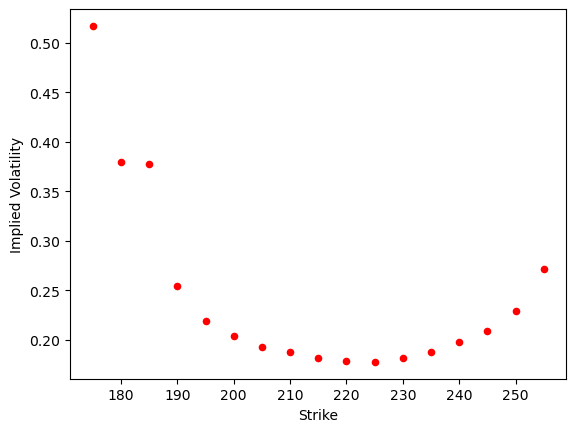

In [17]:
## Call Volatility Smirk

df_call = df_call[df_call["Implied Volatility"] > 0]
df_call["Strike"] = df_call["Strike"].astype(float)

# We will only consider those options within a certain range of the current price
df_call = df_call[df_call["Strike"] > price * 0.8]  

# One reason for this is that it is precisely those options that are most often traded.
df_call = df_call[df_call["Strike"] < price * 1.2] 

df_call_39 = df_call[df_call['Days to maturity']==39]
df_call_39.plot(kind="scatter", x="Strike", y="Implied Volatility", color="red")
plt.show()

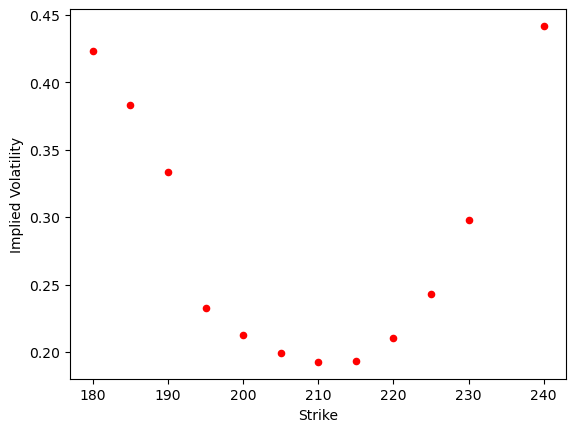

In [4]:
## Put Volatility Smirk

df_put = df_put[df_put["Implied Volatility"] > 0]
df_put["Strike"] = df_put["Strike"].astype(float)
df_put = df_put[df_put["Strike"] > price * 0.8]
df_put = df_put[df_put["Strike"] < price * 1.2]

df_put_25 = df_put[df_put['Days to maturity']==25]
df_put_25.plot(kind="scatter", x="Strike", y="Implied Volatility", color="red")
plt.show()

In local volatility models such as Dupire, implied volatility from option prices is not expressed only as a function of moneyness (as in Black-Scholes framework), but also depends on the maturity of the contract.

This creates a 3-D dependence of implied volatility, and we'll move from a volatility smile to a volatility surface (3D).

Defined moneyness as $\log\left( \frac{K}{S_t} \right)$, so a moneyness of 0 refers to ATM point.

NB: As the option is more ITM, the premium of the call option increases.

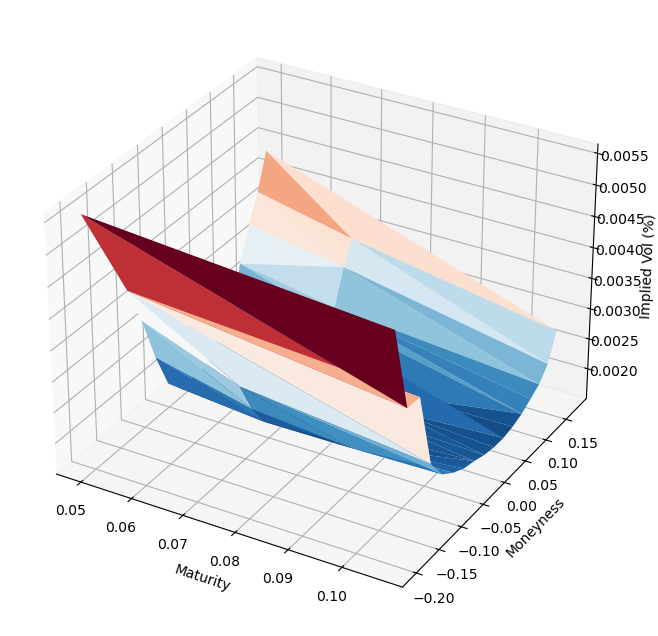

In [5]:
callData = df_call

callData = callData[callData['Implied Volatility']<90]
callData = callData[callData['Implied Volatility']>0]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(callData['Days to maturity']/365, np.log(callData['Strike']/price), callData['Implied Volatility']/100, cmap=plt.cm.RdBu_r, linewidth=0)

# set axis labels
ax.set_xlabel('Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Vol (%)')

plt.show()

The availability of options with different strikes decreases as we move away from the ATM strike. That is, near ATM, there are options available for a wide range of strikes with little increments from one another. 

When we move away from this point, there are larger differences between one option's strike and the strike of the next available one. 

This produces certain spikes in the volatility surface, making it less smooth than sometimes desirable.

In practice, if you want a smoother ("more continuous") volatility surface, you will need to interpolate the volatility surface.

## Newton-Raphson Method

Here we iterate and update our volatility parameter, $\sigma$, according to:
$$\sigma_{i+1} = \sigma_i - \frac{f(\sigma_i)}{f'(\sigma_i)}, \hspace{10pt} \forall i \ge 0$$

In [6]:
#Load CDF and PDF
N_prime = norm.pdf
N = norm.cdf

# Objective function = f = Black-Scholes
def black_scholes(S, K, T, r, sigma, opttyp):
    # Black-Scholes Formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if opttyp == "C": #Call option
        bs = S * N(d1) - N(d2) * K * np.exp(-r * T)
    else: #Put option
        bs = N(-d2) * K * np.exp(-r * T) - S * N(-d1)
        
    return bs

In [7]:
# f' = vega of option
def vega(S, K, T, r, sigma):
    # Calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    
    vega = S * np.sqrt(T) * N_prime(d1)
    return vega

In [8]:
print(vega(S=100, K=100, T=30/365, r=0.05, sigma=0.25))

11.387780714587437


In [9]:
# Recursive process for given level of tolerance & max. no. of iterations
def implied_volatility(C, S, K, T, r, opttyp, tol=0.0001, max_iterations=100):
    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3

    for i in range(max_iterations):
        # calculate difference between black-scholes price and market price with
        # iteratively updated volatility estimate
        diff = black_scholes(S, K, T, r, sigma, opttyp) - C
        print(i)
        
        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print(f"found on {i+1}th iteration")
            print(f"difference is equal to {diff}")
            break

        # use Newton-Rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [36]:
# Example 
observed_price = 18; S = 100
K = 115; T = 1; r = 0.05

imp_vol = implied_volatility(observed_price, S, K, T, r, "P")
print("Implied volatility using Newton Rapshon is: ", imp_vol)

0
1
2
found on 3th iteration
difference is equal to -1.1388100062958983e-07
Implied volatility using Newton Rapshon is:  0.3686708416807875


# Local Volatility Models

### Constant Elasticity of Variance (CEV)

The functional form for call option price based on the following diffusion for underlying asset:
$$dS = \mu(S,t)dt + \sigma(S,t)dZ$$
with
$$\sigma(S,t) = \sigma S^{\frac{\beta}{2}}, 0 \le \beta <2$$
$$\mu(S,t) = rS$$

Assuming $\sigma = 0.35$, $\beta = 1.25$ and $r = 0.05$

In [34]:
def C(t, K, sigma, beta, r, S0):
    zb = 2 + 2/(2 - beta)
    kappa = 2*r / (sigma**2 * (2-beta) * (np.exp(r*(2-beta)*t) -1))
    x = kappa * S0**(2-beta) * np.exp(r*(2-beta)*t)
    y = kappa * K**(2-beta)

    return S0 * (1-ncx2.cdf(2*y, zb, 2*x)) - K*np.exp(-r*t)*(ncx2.cdf(2*x, zb-2, 2*y))

In [45]:
C(t=4/12, K=32.5, sigma=0.25, beta=1.5, r=0.05, S0=35)

3.0938124080539353

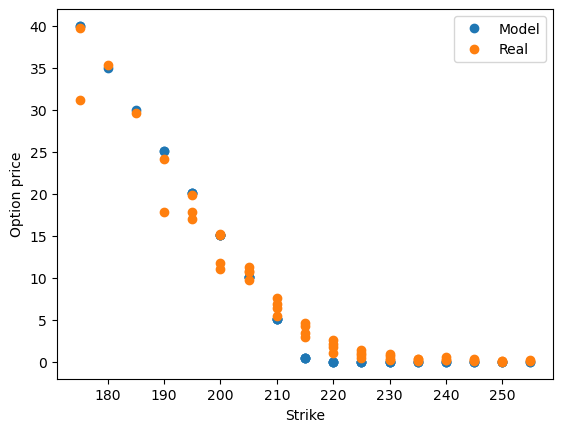

In [25]:
#Variables
S0 = 214.23
r = 0.05
Td = 32/365

sigma = 0.9
beta = 0.5

test_strikes = df_call['Strike']
modelprices = C(Td, test_strikes, sigma, beta, r)
realprices = df_call['Last Price']

plt.plot(test_strikes, modelprices, 'o', label = 'Model')
plt.plot(test_strikes, realprices, 'o', label = 'Real')
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.legend()

Clearly, our model is not doing very well in replicating the observed option prices. There are even negative option prices!

### CEV Model Calibration

Now we'll minimize the error between our CEV model prices and prices observed in the market. This is through changing parameters $\sigma$ and $\beta$ in the CEV model.

NB: Defined error function as mean squared error (MSE).

In [41]:
#MSE
def error(params):
    sigma = params[0]
    beta = params[1]

    t=1 
    S0=220 
    r=0.02
    K = np.array([205, 210, 215, 225]) #[205, 210, 215, 225]
    #Model price calc using C function
    modelprices = C(t, K, sigma, beta, r, S0) 

    #Real prices from dataframe
    #realprices = df_call['Last Price']
    realprices = np.array([18.94, 13.99, 9.32, 1.83])#[18.94, 13.99, 9.32, 1.83]

    mse = mean_squared_error(modelprices, realprices)

    return mse #To be minimized

In [43]:
# Example bounds, adjust as necessary
bnds = ((0.2, 0.5), (0, 1.3))  
init_guess = (0.25, 1.05)

# Perform the optimization
res = minimize(error, init_guess, bounds=bnds, options={'disp': True})

#sigma & beta
res.x[0], res.x[1]

(0.20425116493287163, 1.2033979193595685)

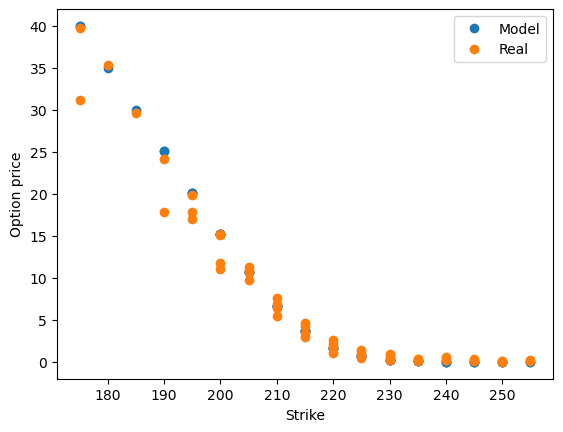

In [30]:
modelprices = C(Td, test_strikes, res.x[0], res.x[1])
#realprices = df_call['Last Price']

plt.plot(test_strikes, modelprices, 'o', label = 'Model')
plt.plot(test_strikes, realprices, 'o', label = 'Real')
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.legend()